In [1]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path 
import re 
import scipy.stats as stats

In [ ]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_2")
fig_out_dir.mkdir(exist_ok=True, parents=True)

## Load data

In [41]:
results = pd.read_csv(out_dir / "experiment_3_main_fba_arch_and_saddler_2024_texture_stim_results.csv")

# Correlation scatter plots


In [46]:
## Compute noise corrected accuracy
# First compute 10,000 split half reliabilities for human data and model data separately    
# Then compute spearman brown correction using averaged reliability  
from tqdm import tqdm

np.random.seed(0)


# split half reliability
def split_half_reliability(data, n_splits=10000):
    reliabilities = np.zeros(n_splits)
    for i in tqdm(range(n_splits)):
        split1 = data.sample(frac=0.5)
        split2 = data.drop(split1.index)
        split1 = split1.groupby('texture_label')['accuracy'].mean().values
        split2 = split2.groupby('texture_label')['accuracy'].mean().values
        r, p = stats.pearsonr(split1, split2)
        reliabilities[i] = r
    mean_r = np.mean(reliabilities)
    split_half_r = (2*mean_r) / (1 + mean_r)
    return split_half_r, reliabilities


human_df = results[results.model.str.contains('Participants')].reset_index(drop=True)

human_rho, human_reliabilities = split_half_reliability(human_df, n_splits=10000)

model_results_for_comp = results[(results.snr == -3) & (results.model == 'word_task_v10_main_feature_gain_config')]
model_rho, model_reliabilities = split_half_reliability(model_results_for_comp, n_splits=10000)

human_perf = human_df.groupby('texture_label')['accuracy'].agg(['mean', 'sem']).reset_index()
model_perf = model_results_for_comp.groupby('texture_label')['accuracy'].agg(['mean', 'sem']).reset_index()
r_model_human, p = stats.pearsonr(model_perf['mean'].values, human_perf['mean'].values)

# spearman brown correction
spearman_brown_r = r_model_human / np.sqrt(human_rho * model_rho)




100%|██████████| 10000/10000 [00:40<00:00, 247.64it/s]


Text(0.5, 1.05, 'Experiment 3: Speech in textures')

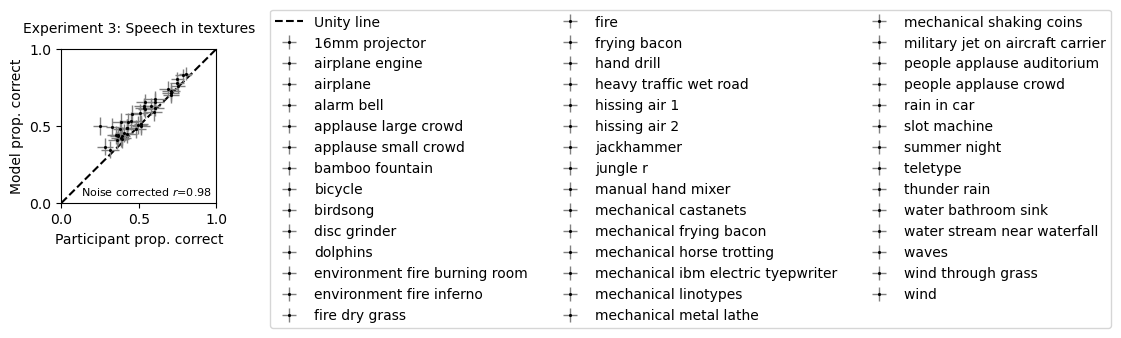

In [47]:
# plot human performance against model performance
fig, axs =  plt.subplots(1,1, figsize=(2,2))
fontsize=10
# make  palette for texture labels
palette = sns.color_palette("husl", len(human_perf))
to_plot = human_perf.copy()
to_plot['texture_label'] = [label.replace('_', ' ').replace('yout', '') for label in to_plot['texture_label']]

x = y = np.linspace(0,1,5)

# plot data with 2 sem error bars
axs.plot(x,y, ls='dashed', color='k', label='Unity line')

for i, row in to_plot.iterrows():
    axs.errorbar(x=row['mean'], y=model_perf.iloc[i]['mean'],
              xerr = row['sem']*2, yerr=model_perf.iloc[i]['sem']*2, fmt='.', 
              label=row['texture_label'],
              color='k',
              ecolor='grey', 
              lw=1,
              markersize=2.5,
              alpha=1,
              )

axs.set_xlabel('Participant prop. correct')
axs.set_ylabel('Model prop. correct')

# add correlation as text
axs.annotate(f"Noise corrected $r$={spearman_brown_r:.2f}", (0.125, 0.05), fontsize=fontsize-2)
axs.set_ylim(0,1)
axs.set_yticks(np.arange(0, 1.1, 0.5))
axs.set_xticks(np.arange(0, 1.1, 0.5))
axs.set_xlim(0,1)

# add legend
axs.legend( loc='upper left', ncol=3, bbox_to_anchor=(1.3,1.3))
plt.title("Experiment 3: Speech in textures", fontsize=fontsize, y=1.05) 

# plt.savefig(fig_out_dir / "experiment_3_scatterplot.pdf", bbox_inches='tight', transparent=True)